# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

model: ring in front of diffuse oscillating component and noise

In [2]:
DEVICE = 'cuda:0'
NDIM = 1 # number of parameters
SIGMA = 0.3

In [3]:
SIGMA = 0.1
w=0.05
def model(z,dat=None):
    grid = np.linspace(0, 1, 50, 50)
    X, Y = np.meshgrid(grid, grid)
    
    if dat is None:
        dat=np.random.uniform(0,1,(6))
    
    #x01, y01, r1, w1,fx,fy,Amp = z[0], z[1], z[2]*0.4+0.2, z[3]*0.1+0.05,\
    #    z[4]*6*np.pi,z[5]*6*np.pi,z[6]
    #x01, y01, r1, w1,x02, y02, r2, w2 = z[0], z[1], z[2]*0.4+0.2, z[3]*0.1+0.05,\
    #    z[4], z[5], z[6]*0.4+0.2, z[7]*0.1+0.05
    #x01, y01, r1,x02, y02, r2 = z[0], z[1], z[2]*0.4+0.2, z[3], z[4], z[5]*0.4+0.2
    x1,y1,x2,y2,x3,y3,r=dat[0],dat[1],dat[2],dat[3],dat[4],dat[5],z[0]*0.4#,z[7],z[8],z[9],z[10]*0.4
    
    #R1 = ((X-x01)**2 + (Y-y01)**2)**0.5+0.3*Amp*np.cos(fx*X)*np.sin(fy*Y)
    R1 = ((X-x1)**2 + (Y-y1)**2)**0.5
    R2 = ((X-x2)**2 + (Y-y2)**2)**0.5
    R3 = ((X-x3)**2 + (Y-y3)**2)**0.5
    #R4 = ((X-x4)**2 + (Y-y4)**2)**0.5
    #R5 = ((X-x5)**2 + (Y-y5)**2)**0.5
    
    #mu = np.exp(-(R1-r1)**2/w1**2/2)+np.exp(-(R2-r2)**2/w2**2/2)#0.3*Amp*np.cos(fx*X)*np.sin(fy*Y)
    #mu = np.exp(-(R1-r1)**2/0.1**2/2)+np.exp(-(R2-r2)**2/0.1**2/2)#0.3*Amp*np.cos(fx*X)*np.sin(fy*Y)
    mu = np.exp(-(R1-r)**2/w**2/2)+np.exp(-(R2-r)**2/w**2/2)+np.exp(-(R3-r)**2/w**2/2)#+np.exp(-(R4-r)**2/w**2/2)+np.exp(-(R5-r)**2/w**2/2)
    x = mu
    return x
def noisemodel(x, z = None, noiselevel = 1.):
    n = np.random.randn(*x.shape)*SIGMA  #*noiselevel
    return x + n

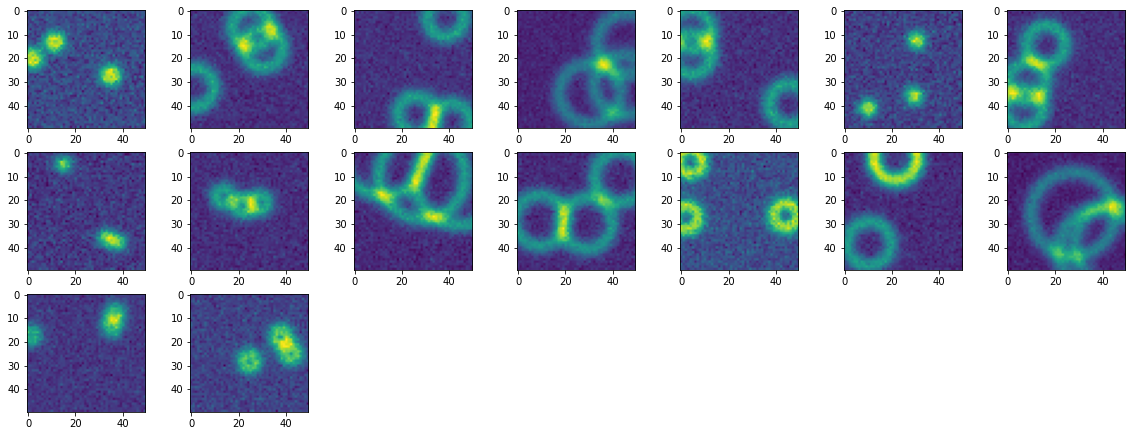

In [5]:
# Random image realizations

plt.figure(figsize=(20, 10))
for i in range(16):
    plt.subplot(4, 7, i+1)
    z = np.random.rand(7)
    x = model(z)
    x = noisemodel(x)
    plt.imshow(x)

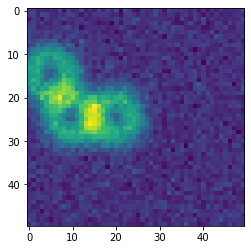

In [4]:
dd=np.array([0.1,0.3,0.4,0.5,0.2,0.5])
z0 = np.array([0.2])
x0 = noisemodel(model(z0,dat=dd))
plt.imshow(x0)

In [6]:
# Fisher analysis
grad = []

for i in range(0, NDIM):
    dz = np.zeros(NDIM)
    d = 0.001
    dz[i] += d
    g = (model(z0+dz) - model(z0))/d
    grad.append(g)

I = np.zeros((NDIM, NDIM))

for i in range(NDIM):
    for j in range(NDIM):
        I[i, j] = (grad[i]*grad[j]).sum()/SIGMA**2
        
        
Cov = np.linalg.inv(I)
err = np.diag(Cov)**0.5
print(err)

[5.13867283e-06]


In [8]:
# Convolutional network as HEAD of inference network

class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #self.conv0a = torch.nn.Conv2d(1, 100, 1)
        #self.conv0b = torch.nn.Conv2d(100, 1, 1)
        self.conv1 = torch.nn.Conv2d(1, 10, 5)
        self.conv2 = torch.nn.Conv2d(10, 20, 5)
        self.conv3 = torch.nn.Conv2d(20, 40, 5)
        self.pool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        nbatch = len(x)
        
        x = x.unsqueeze(1)
        #x = self.conv0a(x)
        #x = torch.relu(x)
        #x = self.conv0b(x)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x

In [9]:
import time

In [10]:
# Instantiate network
sw = swyft.SWYFT(x0, model, zdim = NDIM, device = DEVICE, head = Head, noisemodel = noisemodel)
ch1=time.time()
sw.run(nworkers=0, nrounds = 16, max_epochs = 50, early_stopping_patience = 2, nsamples = 10000, nbatch = 512, recycle_net = True, threshold = 1e-6)
ch2=time.time()
print(str((ch2-ch1)/60))

Adding samples.: 100%|██████████| 9846/9846 [00:00<00:00, 45830.28it/s]


Adding 9846 new samples.


Extracting samples.: 100%|██████████| 9846/9846 [00:00<00:00, 49968.68it/s]


Extracted 9846 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 10
Validation losses: [2.7024574279785156, 2.555211067199707, 2.302155017852783, 1.9764759540557861, 1.8969308137893677, 1.8629302978515625, 1.8080174922943115, 1.807715892791748, 1.8235455751419067, 1.8121448755264282]
LR iteration 1
Total epochs: 3
Validation losses: [1.74601411819458, 1.7651779651641846, 1.7660741806030273]
LR iteration 2
Total epochs: 4
Validation losses: [1.7617413997650146, 1.7496228218078613, 1.7619510889053345, 1.7544625997543335]


Extracting samples.:  75%|███████▌  | 7394/9849 [00:00<00:00, 36990.47it/s]

Adding 3 new samples.


Extracting samples.: 100%|██████████| 9849/9849 [00:00<00:00, 36906.43it/s]


Extracted 9849 samples
Start training
LR iteration 0
Total epochs: 12
Validation losses: [1.866593599319458, 1.6895915269851685, 1.6518224477767944, 1.606945276260376, 1.6010030508041382, 1.5909128189086914, 1.5864908695220947, 1.5825855731964111, 1.5889933109283447, 1.5755412578582764, 1.599632978439331, 1.6560664176940918]
LR iteration 1
Total epochs: 5
Validation losses: [1.5446699857711792, 1.5505142211914062, 1.5150563716888428, 1.5394175052642822, 1.5301520824432373]
LR iteration 2
Total epochs: 5
Validation losses: [1.529038906097412, 1.5405292510986328, 1.5169148445129395, 1.5352180004119873, 1.5460264682769775]


Adding samples.: 100%|██████████| 9893/9893 [00:00<00:00, 33113.09it/s]
Adding simulations: 0it [00:00, ?it/s]
Extracting samples.:  59%|█████▉    | 5832/9849 [00:00<00:00, 29147.21it/s]

Adding 0 new samples.


Extracting samples.: 100%|██████████| 9849/9849 [00:00<00:00, 29054.39it/s]


Extracted 9849 samples
Start training
LR iteration 0
Total epochs: 9
Validation losses: [1.7141406536102295, 1.5716135501861572, 1.5315654277801514, 1.519334077835083, 1.4649486541748047, 1.520136833190918, 1.4280606508255005, 1.486799955368042, 1.511012077331543]
LR iteration 1
Total epochs: 6
Validation losses: [1.4471790790557861, 1.421196699142456, 1.4296107292175293, 1.419820785522461, 1.4333521127700806, 1.4329032897949219]
LR iteration 2
Total epochs: 3
Validation losses: [1.4002609252929688, 1.4151611328125, 1.4190633296966553]


Adding samples.: 100%|██████████| 10083/10083 [00:00<00:00, 26776.78it/s]


Adding 1498 new samples.


Extracting samples.: 100%|██████████| 11347/11347 [00:00<00:00, 24870.92it/s]


Extracted 9847 samples
Start training
LR iteration 0
Total epochs: 7
Validation losses: [1.8150198459625244, 1.6056642532348633, 1.5845131874084473, 1.5974152088165283, 1.578193187713623, 1.5871660709381104, 1.638880729675293]
LR iteration 1
Total epochs: 4
Validation losses: [1.5992257595062256, 1.536512851715088, 1.5399119853973389, 1.5454680919647217]
LR iteration 2
Total epochs: 5
Validation losses: [1.5305030345916748, 1.512542963027954, 1.5024363994598389, 1.5537359714508057, 1.5401506423950195]


Extracting samples.:  37%|███▋      | 4201/11498 [00:00<00:00, 20756.10it/s]

Adding 151 new samples.


Extracting samples.: 100%|██████████| 11498/11498 [00:00<00:00, 21239.15it/s]


Extracted 9827 samples
Start training
LR iteration 0
Total epochs: 5
Validation losses: [1.4444648027420044, 1.2924319505691528, 1.2792384624481201, 1.2876955270767212, 1.3219046592712402]
LR iteration 1
Total epochs: 8
Validation losses: [1.2240614891052246, 1.2325838804244995, 1.213061809539795, 1.225092887878418, 1.201364517211914, 1.183225154876709, 1.2109489440917969, 1.2130781412124634]
LR iteration 2
Total epochs: 5
Validation losses: [1.2175202369689941, 1.2056341171264648, 1.1794822216033936, 1.2087700366973877, 1.2415688037872314]


Adding samples.: 100%|██████████| 10090/10090 [00:00<00:00, 18415.33it/s]


Adding 1046 new samples.


Extracting samples.: 100%|██████████| 12544/12544 [00:00<00:00, 17831.35it/s]


Extracted 9939 samples
Start training
LR iteration 0
Total epochs: 6
Validation losses: [1.6650245189666748, 1.4667534828186035, 1.4090572595596313, 1.3553524017333984, 1.3816208839416504, 1.4581464529037476]
LR iteration 1
Total epochs: 5
Validation losses: [1.3752503395080566, 1.3299479484558105, 1.3283562660217285, 1.380842924118042, 1.3514015674591064]
LR iteration 2
Total epochs: 7
Validation losses: [1.3663334846496582, 1.3547190427780151, 1.3525481224060059, 1.3429598808288574, 1.3140127658843994, 1.372251033782959, 1.3454558849334717]


Adding samples.: 100%|██████████| 10119/10119 [00:00<00:00, 15884.22it/s]


Adding 717 new samples.


Extracting samples.: 100%|██████████| 13261/13261 [00:00<00:00, 15943.56it/s]


Extracted 9995 samples
Start training
LR iteration 0
Total epochs: 5
Validation losses: [1.5711612701416016, 1.388070821762085, 1.3825929164886475, 1.4106215238571167, 1.3827252388000488]
LR iteration 1
Total epochs: 8
Validation losses: [1.3692710399627686, 1.3633743524551392, 1.3859779834747314, 1.3592801094055176, 1.356352686882019, 1.3367513418197632, 1.373826265335083, 1.3732107877731323]
LR iteration 2
Total epochs: 7
Validation losses: [1.3540422916412354, 1.3575127124786377, 1.3464269638061523, 1.3809585571289062, 1.3292378187179565, 1.3456647396087646, 1.3330442905426025]


Adding samples.: 100%|██████████| 9854/9854 [00:00<00:00, 15193.43it/s]


Adding 1217 new samples.


Extracting samples.: 100%|██████████| 14478/14478 [00:00<00:00, 15522.48it/s]


Extracted 9971 samples
Start training
LR iteration 0
Total epochs: 7
Validation losses: [1.4797117710113525, 1.258066177368164, 1.2475087642669678, 1.2075978517532349, 1.2074673175811768, 1.2398183345794678, 1.2544183731079102]
LR iteration 1
Total epochs: 4
Validation losses: [1.1812994480133057, 1.14524507522583, 1.1694788932800293, 1.1481943130493164]
LR iteration 2
Total epochs: 6
Validation losses: [1.1926827430725098, 1.1856026649475098, 1.175172209739685, 1.160018801689148, 1.1778112649917603, 1.188484787940979]


Adding samples.: 100%|██████████| 10001/10001 [00:00<00:00, 10772.45it/s]


Adding 1756 new samples.


Extracting samples.: 100%|██████████| 16234/16234 [00:01<00:00, 11346.53it/s]


Extracted 9992 samples
Start training
LR iteration 0
Total epochs: 7
Validation losses: [1.6556260585784912, 1.4471533298492432, 1.4371497631072998, 1.4422072172164917, 1.4306905269622803, 1.4477957487106323, 1.469550371170044]
LR iteration 1
Total epochs: 8
Validation losses: [1.4189685583114624, 1.3916007280349731, 1.387972354888916, 1.3763878345489502, 1.401055097579956, 1.3604487180709839, 1.4180960655212402, 1.3899829387664795]
LR iteration 2
Total epochs: 5
Validation losses: [1.3857972621917725, 1.3962980508804321, 1.365471363067627, 1.3697080612182617, 1.4111626148223877]


Adding samples.: 100%|██████████| 10015/10015 [00:01<00:00, 9940.91it/s]


Adding 1086 new samples.


Extracting samples.: 100%|██████████| 17320/17320 [00:01<00:00, 10638.47it/s]


Extracted 9954 samples
Start training
LR iteration 0
Total epochs: 10
Validation losses: [1.6653735637664795, 1.3871408700942993, 1.2727614641189575, 1.2685315608978271, 1.285553216934204, 1.2247228622436523, 1.1940460205078125, 1.1720503568649292, 1.2196868658065796, 1.2542734146118164]
LR iteration 1
Total epochs: 5
Validation losses: [1.1916087865829468, 1.2418957948684692, 1.1802024841308594, 1.217702865600586, 1.2326531410217285]
LR iteration 2
Total epochs: 4
Validation losses: [1.2295814752578735, 1.193960189819336, 1.2311595678329468, 1.224359154701233]


Adding samples.: 100%|██████████| 10067/10067 [00:00<00:00, 11353.45it/s]


Adding 506 new samples.


Extracting samples.: 100%|██████████| 17826/17826 [00:01<00:00, 12617.77it/s]


Extracted 10035 samples
Start training
LR iteration 0
Total epochs: 6
Validation losses: [1.6502280235290527, 1.5241562128067017, 1.526831865310669, 1.438581943511963, 1.4709235429763794, 1.4911600351333618]
LR iteration 1
Total epochs: 3
Validation losses: [1.4086554050445557, 1.4351377487182617, 1.435835599899292]
LR iteration 2
Total epochs: 5
Validation losses: [1.4118340015411377, 1.4138903617858887, 1.3971843719482422, 1.3994312286376953, 1.4206669330596924]


Extracting samples.:  14%|█▍        | 2498/17849 [00:00<00:01, 12490.34it/s]

Adding 23 new samples.


Extracting samples.: 100%|██████████| 17849/17849 [00:01<00:00, 11797.70it/s]


Extracted 10020 samples
Start training
LR iteration 0
Total epochs: 5
Validation losses: [1.4547890424728394, 1.3092336654663086, 1.2881147861480713, 1.337741732597351, 1.3453378677368164]
LR iteration 1
Total epochs: 3
Validation losses: [1.2431837320327759, 1.2491345405578613, 1.2602380514144897]
LR iteration 2
Total epochs: 6
Validation losses: [1.2817796468734741, 1.2692651748657227, 1.2796244621276855, 1.263232946395874, 1.2660143375396729, 1.2644535303115845]


Extracting samples.:   7%|▋         | 1186/18196 [00:00<00:01, 11859.11it/s]

Adding 347 new samples.


Extracting samples.: 100%|██████████| 18196/18196 [00:01<00:00, 11087.54it/s]


Extracted 10063 samples
Start training
LR iteration 0
Total epochs: 7
Validation losses: [1.4816744327545166, 1.2643088102340698, 1.2589918375015259, 1.253506064414978, 1.2115850448608398, 1.267246961593628, 1.2863035202026367]
LR iteration 1
Total epochs: 3
Validation losses: [1.180121660232544, 1.1950522661209106, 1.2064379453659058]
LR iteration 2
Total epochs: 3
Validation losses: [1.1713566780090332, 1.2446746826171875, 1.1807451248168945]


Adding samples.: 100%|██████████| 10004/10004 [00:01<00:00, 9302.22it/s]


Adding 793 new samples.


Extracting samples.: 100%|██████████| 18989/18989 [00:01<00:00, 10427.98it/s]


Extracted 10066 samples
Start training
LR iteration 0
Total epochs: 5
Validation losses: [1.4906690120697021, 1.3937758207321167, 1.3295986652374268, 1.36112642288208, 1.3924812078475952]
LR iteration 1
Total epochs: 3
Validation losses: [1.2746044397354126, 1.2952229976654053, 1.348764419555664]
LR iteration 2
Total epochs: 4
Validation losses: [1.3096437454223633, 1.2990342378616333, 1.320587158203125, 1.3384040594100952]


Extracting samples.:  11%|█▏        | 2144/19000 [00:00<00:01, 10715.12it/s]

Adding 11 new samples.


Extracting samples.: 100%|██████████| 19000/19000 [00:01<00:00, 9926.39it/s] 


Extracted 10044 samples
Start training
LR iteration 0
Total epochs: 6
Validation losses: [1.5389628410339355, 1.3434337377548218, 1.2294317483901978, 1.2144643068313599, 1.3073742389678955, 1.2797269821166992]
LR iteration 1
Total epochs: 7
Validation losses: [1.2228400707244873, 1.2076010704040527, 1.195706844329834, 1.1988632678985596, 1.1680713891983032, 1.1909534931182861, 1.1929963827133179]
LR iteration 2
Total epochs: 4
Validation losses: [1.177161693572998, 1.169447422027588, 1.2120378017425537, 1.2166826725006104]


Adding samples.: 100%|██████████| 10017/10017 [00:01<00:00, 8224.59it/s]


Adding 732 new samples.


Extracting samples.: 100%|██████████| 19732/19732 [00:02<00:00, 9391.99it/s] 


Extracted 10065 samples
Start training
LR iteration 0
Total epochs: 7
Validation losses: [1.635001540184021, 1.4915647506713867, 1.449652910232544, 1.5062668323516846, 1.416349172592163, 1.5072896480560303, 1.422975778579712]
LR iteration 1
Total epochs: 3
Validation losses: [1.369187593460083, 1.3948578834533691, 1.3911607265472412]
LR iteration 2
Total epochs: 5
Validation losses: [1.3908085823059082, 1.3949027061462402, 1.3293853998184204, 1.3779497146606445, 1.3446789979934692]
15.044435207049052


In [19]:
ch1=time.time()
sw.run(nworkers=0, nrounds = 16, max_epochs = 50, early_stopping_patience = 1, nsamples = 10000, nbatch = 512, recycle_net = True, threshold = 1e-6)
ch2=time.time()
print(str((ch2-ch1)/60))

Extracting samples.:  10%|▉         | 1922/19749 [00:00<00:01, 9492.49it/s]

Adding 17 new samples.


Extracting samples.: 100%|██████████| 19749/19749 [00:02<00:00, 8892.71it/s]


Extracted 10077 samples
Start training
LR iteration 0
Total epochs: 5
Validation losses: [1.753636121749878, 1.445860505104065, 1.272374153137207, 1.2108361721038818, 1.3082088232040405]
LR iteration 1
Total epochs: 3
Validation losses: [1.1768120527267456, 1.1313377618789673, 1.160810947418213]
LR iteration 2
Total epochs: 2
Validation losses: [1.160271406173706, 1.1616709232330322]


Adding samples.: 100%|██████████| 9906/9906 [00:01<00:00, 7108.53it/s]
Adding simulations: 0it [00:00, ?it/s]
Extracting samples.:   5%|▍         | 901/19749 [00:00<00:02, 9005.59it/s]

Adding 0 new samples.


Extracting samples.: 100%|██████████| 19749/19749 [00:02<00:00, 8282.62it/s]


Extracted 10064 samples
Start training
LR iteration 0
Total epochs: 5
Validation losses: [1.3815401792526245, 1.1203386783599854, 1.1118865013122559, 1.0703190565109253, 1.1176846027374268]
LR iteration 1
Total epochs: 2
Validation losses: [1.046094536781311, 1.0836734771728516]
LR iteration 2
Total epochs: 3
Validation losses: [1.0953733921051025, 1.0681867599487305, 1.0838584899902344]


Adding samples.: 100%|██████████| 10090/10090 [00:01<00:00, 6733.46it/s]


Adding 1495 new samples.


Extracting samples.: 100%|██████████| 21244/21244 [00:02<00:00, 7814.79it/s]


Extracted 10078 samples
Start training
LR iteration 0
Total epochs: 3
Validation losses: [1.7044692039489746, 1.5009045600891113, 1.506252646446228]
LR iteration 1
Total epochs: 5
Validation losses: [1.5000224113464355, 1.470577359199524, 1.4402498006820679, 1.4171812534332275, 1.453241229057312]
LR iteration 2
Total epochs: 2
Validation losses: [1.4521293640136719, 1.4808599948883057]


Extracting samples.:   8%|▊         | 1691/21359 [00:00<00:02, 8441.17it/s]

Adding 115 new samples.


Extracting samples.: 100%|██████████| 21359/21359 [00:02<00:00, 7548.97it/s]


Extracted 10157 samples
Start training
LR iteration 0
Total epochs: 2
Validation losses: [1.370308756828308, 1.4027788639068604]
LR iteration 1
Total epochs: 6
Validation losses: [1.3686085939407349, 1.3175632953643799, 1.293991208076477, 1.2930889129638672, 1.2740850448608398, 1.329038381576538]
LR iteration 2
Total epochs: 4
Validation losses: [1.2797104120254517, 1.2428486347198486, 1.2410826683044434, 1.263562560081482]


Adding samples.: 100%|██████████| 9860/9860 [00:01<00:00, 6166.41it/s]


Adding 777 new samples.


Extracting samples.: 100%|██████████| 22136/22136 [00:03<00:00, 7309.99it/s]


Extracted 10092 samples
Start training
LR iteration 0
Total epochs: 5
Validation losses: [1.754206657409668, 1.5356299877166748, 1.490670919418335, 1.3805042505264282, 1.4673666954040527]
LR iteration 1
Total epochs: 4
Validation losses: [1.4278368949890137, 1.4264689683914185, 1.4042079448699951, 1.40916109085083]
LR iteration 2
Total epochs: 3
Validation losses: [1.417272686958313, 1.3705638647079468, 1.3902783393859863]


Adding samples.: 100%|██████████| 10089/10089 [00:01<00:00, 5894.51it/s]


Adding 1204 new samples.


Extracting samples.: 100%|██████████| 23340/23340 [00:03<00:00, 7016.49it/s]


Extracted 10176 samples
Start training
LR iteration 0
Total epochs: 3
Validation losses: [1.7907272577285767, 1.4029593467712402, 1.4065589904785156]
LR iteration 1
Total epochs: 3
Validation losses: [1.3986188173294067, 1.3516865968704224, 1.3534274101257324]
LR iteration 2
Total epochs: 3
Validation losses: [1.3712453842163086, 1.333774447441101, 1.3703296184539795]


Extracting samples.:   7%|▋         | 1530/23342 [00:00<00:02, 7618.77it/s]

Adding 2 new samples.


Extracting samples.: 100%|██████████| 23342/23342 [00:03<00:00, 6603.65it/s]


Extracted 10099 samples
Start training
LR iteration 0
Total epochs: 6
Validation losses: [1.5951542854309082, 1.41683030128479, 1.3511195182800293, 1.3233129978179932, 1.3222308158874512, 1.3520838022232056]
LR iteration 1
Total epochs: 2
Validation losses: [1.2453107833862305, 1.2611318826675415]
LR iteration 2
Total epochs: 2
Validation losses: [1.2828302383422852, 1.2936804294586182]


Extracting samples.:   7%|▋         | 1563/23369 [00:00<00:02, 7808.80it/s]

Adding 27 new samples.


Extracting samples.: 100%|██████████| 23369/23369 [00:03<00:00, 6775.09it/s]


Extracted 10097 samples
Start training
LR iteration 0
Total epochs: 5
Validation losses: [1.7989784479141235, 1.4793540239334106, 1.4393372535705566, 1.3872876167297363, 1.411808967590332]
LR iteration 1
Total epochs: 4
Validation losses: [1.4124531745910645, 1.3758189678192139, 1.347375512123108, 1.3789361715316772]
LR iteration 2
Total epochs: 4
Validation losses: [1.359386682510376, 1.3129512071609497, 1.30722177028656, 1.3355683088302612]


Extracting samples.:   3%|▎         | 712/23391 [00:00<00:03, 7114.12it/s]

Adding 22 new samples.


Extracting samples.: 100%|██████████| 23391/23391 [00:03<00:00, 6248.87it/s]


Extracted 10137 samples
Start training
LR iteration 0
Total epochs: 6
Validation losses: [1.7733154296875, 1.5509920120239258, 1.485515832901001, 1.4197883605957031, 1.40289306640625, 1.4567761421203613]
LR iteration 1
Total epochs: 2
Validation losses: [1.400010108947754, 1.420295000076294]
LR iteration 2
Total epochs: 6
Validation losses: [1.4381704330444336, 1.4349346160888672, 1.4128248691558838, 1.3860599994659424, 1.368786334991455, 1.4546866416931152]


Extracting samples.:   6%|▋         | 1469/23403 [00:00<00:02, 7319.03it/s]

Adding 12 new samples.


Extracting samples.: 100%|██████████| 23403/23403 [00:03<00:00, 6336.98it/s]


Extracted 10136 samples
Start training
LR iteration 0
Total epochs: 5
Validation losses: [1.7706618309020996, 1.4555436372756958, 1.439733624458313, 1.3779069185256958, 1.3875293731689453]
LR iteration 1
Total epochs: 2
Validation losses: [1.3636873960494995, 1.3894188404083252]
LR iteration 2
Total epochs: 2
Validation losses: [1.3542022705078125, 1.3996036052703857]


Extracting samples.:   6%|▌         | 1430/23429 [00:00<00:03, 7119.29it/s]

Adding 26 new samples.


Extracting samples.: 100%|██████████| 23429/23429 [00:03<00:00, 6148.21it/s]


Extracted 10103 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.749436378479004, 1.6394720077514648, 1.4874677658081055, 1.5059081315994263]
LR iteration 1
Total epochs: 3
Validation losses: [1.408884048461914, 1.3795089721679688, 1.427152395248413]
LR iteration 2
Total epochs: 2
Validation losses: [1.4469112157821655, 1.4644469022750854]


Extracting samples.:   6%|▌         | 1403/23440 [00:00<00:03, 6997.68it/s]

Adding 11 new samples.


Extracting samples.: 100%|██████████| 23440/23440 [00:03<00:00, 6015.52it/s]


Extracted 10087 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.7633001804351807, 1.5218908786773682, 1.4241104125976562, 1.4459373950958252]
LR iteration 1
Total epochs: 2
Validation losses: [1.3761909008026123, 1.4284346103668213]
LR iteration 2
Total epochs: 4
Validation losses: [1.3973392248153687, 1.3889708518981934, 1.3627880811691284, 1.3988808393478394]


Adding samples.: 100%|██████████| 9970/9970 [00:02<00:00, 4714.54it/s]
Adding simulations: 0it [00:00, ?it/s]
Extracting samples.:   6%|▌         | 1353/23440 [00:00<00:03, 6753.11it/s]

Adding 0 new samples.


Extracting samples.: 100%|██████████| 23440/23440 [00:04<00:00, 5819.30it/s]


Extracted 10142 samples
Start training
LR iteration 0
Total epochs: 6
Validation losses: [1.597668170928955, 1.4185340404510498, 1.4056321382522583, 1.3671770095825195, 1.346652626991272, 1.350921869277954]
LR iteration 1
Total epochs: 3
Validation losses: [1.3124862909317017, 1.3042047023773193, 1.3546898365020752]
LR iteration 2
Total epochs: 3
Validation losses: [1.323599934577942, 1.2977312803268433, 1.3212339878082275]


Adding samples.: 100%|██████████| 9952/9952 [00:02<00:00, 4504.30it/s]


Adding 1258 new samples.


Extracting samples.: 100%|██████████| 24698/24698 [00:04<00:00, 5611.72it/s]


Extracted 10196 samples
Start training
LR iteration 0
Total epochs: 6
Validation losses: [1.6302578449249268, 1.4499399662017822, 1.3808612823486328, 1.371569037437439, 1.3193285465240479, 1.3968772888183594]
LR iteration 1
Total epochs: 3
Validation losses: [1.3686583042144775, 1.3137563467025757, 1.3286514282226562]
LR iteration 2
Total epochs: 3
Validation losses: [1.3159096240997314, 1.2844884395599365, 1.3231911659240723]


Extracting samples.:   3%|▎         | 641/25023 [00:00<00:03, 6405.53it/s]

Adding 325 new samples.


Extracting samples.: 100%|██████████| 25023/25023 [00:04<00:00, 5467.65it/s]


Extracted 10194 samples
Start training
LR iteration 0
Total epochs: 3
Validation losses: [1.5857081413269043, 1.3839386701583862, 1.3948376178741455]
LR iteration 1
Total epochs: 5
Validation losses: [1.391215443611145, 1.3806374073028564, 1.331618070602417, 1.2992510795593262, 1.3471006155014038]
LR iteration 2
Total epochs: 2
Validation losses: [1.327111005783081, 1.3295165300369263]


Adding samples.: 100%|██████████| 10083/10083 [00:02<00:00, 4239.23it/s]


Adding 890 new samples.


Extracting samples.: 100%|██████████| 25913/25913 [00:04<00:00, 5292.24it/s]


Extracted 10205 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.8360427618026733, 1.4556703567504883, 1.2800300121307373, 1.3013885021209717]
LR iteration 1
Total epochs: 2
Validation losses: [1.2569570541381836, 1.2728601694107056]
LR iteration 2
Total epochs: 2
Validation losses: [1.2131564617156982, 1.248060941696167]
11.08055310646693


In [22]:
ch1=time.time()
sw.run(nworkers=0, nrounds = 32, max_epochs = 50, early_stopping_patience = 1, nsamples = 10000, nbatch = 512, recycle_net = True, threshold = 1e-6)
ch2=time.time()
print(str((ch2-ch1)/60))

Extracting samples.:   4%|▍         | 980/25951 [00:00<00:05, 4895.11it/s]

Adding 38 new samples.


Extracting samples.: 100%|██████████| 25951/25951 [00:06<00:00, 4080.36it/s]


Extracted 10190 samples
Start training
LR iteration 0
Total epochs: 3
Validation losses: [1.6742188930511475, 1.270796775817871, 1.3087016344070435]
LR iteration 1
Total epochs: 2
Validation losses: [1.2051252126693726, 1.2453811168670654]
LR iteration 2
Total epochs: 2
Validation losses: [1.2153942584991455, 1.252051591873169]


Adding samples.: 100%|██████████| 10052/10052 [00:03<00:00, 3196.70it/s]
Adding simulations: 0it [00:00, ?it/s]
Extracting samples.:   4%|▎         | 967/25951 [00:00<00:05, 4836.22it/s]

Adding 0 new samples.


Extracting samples.: 100%|██████████| 25951/25951 [00:06<00:00, 3983.37it/s]


Extracted 10163 samples
Start training
LR iteration 0
Total epochs: 5
Validation losses: [1.6577057838439941, 1.3304452896118164, 1.2111048698425293, 1.2023847103118896, 1.2176072597503662]
LR iteration 1
Total epochs: 3
Validation losses: [1.1792659759521484, 1.16841459274292, 1.1764140129089355]
LR iteration 2
Total epochs: 2
Validation losses: [1.1424627304077148, 1.1644368171691895]


Extracting samples.:   2%|▏         | 493/26196 [00:00<00:05, 4928.89it/s]

Adding 245 new samples.


Extracting samples.: 100%|██████████| 26196/26196 [00:06<00:00, 4010.14it/s]


Extracted 10137 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.8482061624526978, 1.4508862495422363, 1.3853497505187988, 1.3980040550231934]
LR iteration 1
Total epochs: 3
Validation losses: [1.360651969909668, 1.3370718955993652, 1.3379087448120117]
LR iteration 2
Total epochs: 2
Validation losses: [1.300906777381897, 1.3259459733963013]


Extracting samples.:   4%|▎         | 965/26232 [00:00<00:05, 4847.05it/s]

Adding 36 new samples.


Extracting samples.: 100%|██████████| 26232/26232 [00:06<00:00, 3929.85it/s]


Extracted 10245 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.7091827392578125, 1.4583110809326172, 1.317629337310791, 1.3397027254104614]
LR iteration 1
Total epochs: 3
Validation losses: [1.3018735647201538, 1.2626569271087646, 1.3016886711120605]
LR iteration 2
Total epochs: 2
Validation losses: [1.2387845516204834, 1.3031401634216309]


Extracting samples.:   4%|▎         | 947/26235 [00:00<00:05, 4725.63it/s]

Adding 3 new samples.


Extracting samples.: 100%|██████████| 26235/26235 [00:06<00:00, 3847.96it/s]


Extracted 10166 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.6966447830200195, 1.3623435497283936, 1.3013269901275635, 1.309104084968567]
LR iteration 1
Total epochs: 5
Validation losses: [1.287914514541626, 1.2823776006698608, 1.251369833946228, 1.2200262546539307, 1.2874486446380615]
LR iteration 2
Total epochs: 2
Validation losses: [1.221442461013794, 1.266523838043213]


Extracting samples.:   4%|▍         | 1091/26238 [00:00<00:04, 5391.14it/s]

Adding 3 new samples.


Extracting samples.: 100%|██████████| 26238/26238 [00:05<00:00, 4664.77it/s]


Extracted 10186 samples
Start training
LR iteration 0
Total epochs: 6
Validation losses: [1.3523757457733154, 1.2150449752807617, 1.1629432439804077, 1.1560499668121338, 1.0732048749923706, 1.3084110021591187]
LR iteration 1
Total epochs: 2
Validation losses: [1.1069040298461914, 1.1266545057296753]
LR iteration 2
Total epochs: 2
Validation losses: [1.0590490102767944, 1.156489372253418]


Adding samples.: 100%|██████████| 10135/10135 [00:02<00:00, 3528.22it/s]


Adding 1356 new samples.


Extracting samples.: 100%|██████████| 27594/27594 [00:06<00:00, 4513.26it/s]


Extracted 10107 samples
Start training
LR iteration 0
Total epochs: 5
Validation losses: [1.6343932151794434, 1.427140235900879, 1.3929681777954102, 1.3697717189788818, 1.417130947113037]
LR iteration 1
Total epochs: 2
Validation losses: [1.3155399560928345, 1.3295433521270752]
LR iteration 2
Total epochs: 2
Validation losses: [1.2950013875961304, 1.3230334520339966]


Extracting samples.:   4%|▍         | 1084/27646 [00:00<00:04, 5420.96it/s]

Adding 52 new samples.


Extracting samples.: 100%|██████████| 27646/27646 [00:06<00:00, 4400.57it/s]


Extracted 10134 samples
Start training
LR iteration 0
Total epochs: 6
Validation losses: [1.833100438117981, 1.4465479850769043, 1.3669055700302124, 1.3095533847808838, 1.3017878532409668, 1.309053659439087]
LR iteration 1
Total epochs: 2
Validation losses: [1.264922857284546, 1.3170127868652344]
LR iteration 2
Total epochs: 4
Validation losses: [1.297114610671997, 1.2701613903045654, 1.2577433586120605, 1.2836871147155762]


Extracting samples.:   4%|▍         | 1066/27653 [00:00<00:04, 5326.13it/s]

Adding 7 new samples.


Extracting samples.: 100%|██████████| 27653/27653 [00:06<00:00, 4358.01it/s]


Extracted 10172 samples
Start training
LR iteration 0
Total epochs: 5
Validation losses: [1.5831804275512695, 1.3867292404174805, 1.224521279335022, 1.1982556581497192, 1.2270817756652832]
LR iteration 1
Total epochs: 4
Validation losses: [1.189375638961792, 1.1849267482757568, 1.1297324895858765, 1.1681602001190186]
LR iteration 2
Total epochs: 2
Validation losses: [1.1961811780929565, 1.2200822830200195]


Extracting samples.:   4%|▍         | 1051/27679 [00:00<00:05, 5249.03it/s]

Adding 26 new samples.


Extracting samples.: 100%|██████████| 27679/27679 [00:06<00:00, 4283.95it/s]


Extracted 10153 samples
Start training
LR iteration 0
Total epochs: 3
Validation losses: [1.3065180778503418, 1.2072765827178955, 1.254143476486206]
LR iteration 1
Total epochs: 7
Validation losses: [1.227855920791626, 1.2138683795928955, 1.189874529838562, 1.1761921644210815, 1.161766767501831, 1.1256835460662842, 1.1634446382522583]
LR iteration 2
Total epochs: 2
Validation losses: [1.141624927520752, 1.1615104675292969]


Adding samples.: 100%|██████████| 10159/10159 [00:04<00:00, 2444.43it/s]


Adding 895 new samples.


Extracting samples.: 100%|██████████| 28574/28574 [00:08<00:00, 3336.06it/s]


Extracted 10122 samples
Start training
LR iteration 0
Total epochs: 5
Validation losses: [1.6610236167907715, 1.4837465286254883, 1.4621670246124268, 1.4538257122039795, 1.4751107692718506]
LR iteration 1
Total epochs: 2
Validation losses: [1.3509231805801392, 1.4001706838607788]
LR iteration 2
Total epochs: 4
Validation losses: [1.4061224460601807, 1.390498161315918, 1.3900736570358276, 1.455123782157898]


Extracting samples.:   1%|▏         | 417/28988 [00:00<00:06, 4167.79it/s]

Adding 414 new samples.


Extracting samples.: 100%|██████████| 28988/28988 [00:08<00:00, 3308.17it/s]


Extracted 10107 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.6938536167144775, 1.4654266834259033, 1.3971859216690063, 1.4144840240478516]
LR iteration 1
Total epochs: 4
Validation losses: [1.3652698993682861, 1.3194373846054077, 1.271572470664978, 1.3650057315826416]
LR iteration 2
Total epochs: 4
Validation losses: [1.3336769342422485, 1.3323843479156494, 1.287418007850647, 1.3224495649337769]


Extracting samples.:   3%|▎         | 822/28995 [00:00<00:06, 4103.23it/s]

Adding 7 new samples.


Extracting samples.: 100%|██████████| 28995/28995 [00:09<00:00, 3219.75it/s]


Extracted 10117 samples
Start training
LR iteration 0
Total epochs: 3
Validation losses: [1.4448765516281128, 1.2869292497634888, 1.3085442781448364]
LR iteration 1
Total epochs: 3
Validation losses: [1.31539785861969, 1.266465663909912, 1.2816063165664673]
LR iteration 2
Total epochs: 3
Validation losses: [1.3028031587600708, 1.264586329460144, 1.274581789970398]


Extracting samples.:   3%|▎         | 806/28996 [00:00<00:06, 4030.43it/s]

Adding 1 new samples.


Extracting samples.: 100%|██████████| 28996/28996 [00:09<00:00, 3204.32it/s]


Extracted 10091 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.4854649305343628, 1.334938645362854, 1.243165135383606, 1.259634017944336]
LR iteration 1
Total epochs: 2
Validation losses: [1.211108922958374, 1.2306519746780396]
LR iteration 2
Total epochs: 2
Validation losses: [1.225719690322876, 1.2274787425994873]


Extracting samples.:   3%|▎         | 802/29004 [00:00<00:07, 4007.21it/s]

Adding 8 new samples.


Extracting samples.: 100%|██████████| 29004/29004 [00:09<00:00, 3185.09it/s]


Extracted 10116 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.5153906345367432, 1.4495303630828857, 1.380621314048767, 1.4139600992202759]
LR iteration 1
Total epochs: 4
Validation losses: [1.3963277339935303, 1.3212666511535645, 1.3002190589904785, 1.4063886404037476]
LR iteration 2
Total epochs: 3
Validation losses: [1.374671220779419, 1.3735904693603516, 1.4064819812774658]


Adding samples.: 100%|██████████| 9977/9977 [00:04<00:00, 2302.54it/s]


Adding 1036 new samples.


Extracting samples.: 100%|██████████| 30040/30040 [00:09<00:00, 3099.76it/s]


Extracted 10118 samples
Start training
LR iteration 0
Total epochs: 6
Validation losses: [1.4877407550811768, 1.4187166690826416, 1.3952335119247437, 1.3453948497772217, 1.3413312435150146, 1.3659230470657349]
LR iteration 1
Total epochs: 3
Validation losses: [1.3286798000335693, 1.3008602857589722, 1.320631504058838]
LR iteration 2
Total epochs: 2
Validation losses: [1.343306541442871, 1.363416075706482]


Adding samples.: 100%|██████████| 9978/9978 [00:04<00:00, 2241.82it/s]


Adding 578 new samples.


Extracting samples.: 100%|██████████| 30618/30618 [00:10<00:00, 3032.01it/s]


Extracted 10095 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.2978229522705078, 1.286362648010254, 1.2531388998031616, 1.2583394050598145]
LR iteration 1
Total epochs: 3
Validation losses: [1.2817120552062988, 1.1890954971313477, 1.2320736646652222]
LR iteration 2
Total epochs: 6
Validation losses: [1.2486448287963867, 1.2412033081054688, 1.231824517250061, 1.1805821657180786, 1.1579762697219849, 1.258479356765747]


Adding samples.: 100%|██████████| 9993/9993 [00:04<00:00, 2180.35it/s]


Adding 813 new samples.


Extracting samples.: 100%|██████████| 31431/31431 [00:10<00:00, 2962.59it/s]


Extracted 10063 samples
Start training
LR iteration 0
Total epochs: 5
Validation losses: [1.545814037322998, 1.4622244834899902, 1.4241149425506592, 1.3958746194839478, 1.4661364555358887]
LR iteration 1
Total epochs: 2
Validation losses: [1.3346282243728638, 1.442505121231079]
LR iteration 2
Total epochs: 5
Validation losses: [1.4041223526000977, 1.3730978965759277, 1.362152338027954, 1.297802209854126, 1.3722025156021118]


Extracting samples.:   1%|          | 382/31807 [00:00<00:08, 3809.64it/s]

Adding 376 new samples.


Extracting samples.: 100%|██████████| 31807/31807 [00:10<00:00, 2904.98it/s]


Extracted 10092 samples
Start training
LR iteration 0
Total epochs: 6
Validation losses: [1.8307745456695557, 1.5635840892791748, 1.5007550716400146, 1.4988336563110352, 1.4674588441848755, 1.5304970741271973]
LR iteration 1
Total epochs: 3
Validation losses: [1.5288691520690918, 1.4459822177886963, 1.514303207397461]
LR iteration 2
Total epochs: 2
Validation losses: [1.4542291164398193, 1.4805066585540771]


Extracting samples.:   3%|▎         | 907/31937 [00:00<00:06, 4511.79it/s]

Adding 130 new samples.


Extracting samples.: 100%|██████████| 31937/31937 [00:09<00:00, 3532.46it/s]


Extracted 10099 samples
Start training
LR iteration 0
Total epochs: 5
Validation losses: [1.579963207244873, 1.4566644430160522, 1.441528558731079, 1.4179737567901611, 1.4500774145126343]
LR iteration 1
Total epochs: 3
Validation losses: [1.3871558904647827, 1.3752849102020264, 1.3929649591445923]
LR iteration 2
Total epochs: 3
Validation losses: [1.3966264724731445, 1.3647918701171875, 1.4095776081085205]


Extracting samples.:   1%|▏         | 444/32163 [00:00<00:07, 4432.61it/s]

Adding 226 new samples.


Extracting samples.: 100%|██████████| 32163/32163 [00:09<00:00, 3498.53it/s]


Extracted 10071 samples
Start training
LR iteration 0
Total epochs: 5
Validation losses: [1.558708906173706, 1.4086456298828125, 1.366183876991272, 1.352773904800415, 1.375667691230774]
LR iteration 1
Total epochs: 2
Validation losses: [1.2985308170318604, 1.3625035285949707]
LR iteration 2
Total epochs: 3
Validation losses: [1.3483445644378662, 1.3414287567138672, 1.387600064277649]


Extracting samples.:   3%|▎         | 851/32182 [00:00<00:07, 4232.57it/s]

Adding 19 new samples.


Extracting samples.: 100%|██████████| 32182/32182 [00:09<00:00, 3400.76it/s]


Extracted 10143 samples
Start training
LR iteration 0
Total epochs: 7
Validation losses: [1.675689458847046, 1.3578051328659058, 1.3213989734649658, 1.25758957862854, 1.2166695594787598, 1.2022579908370972, 1.2938973903656006]
LR iteration 1
Total epochs: 6
Validation losses: [1.2519750595092773, 1.2464103698730469, 1.2400778532028198, 1.2323877811431885, 1.186755895614624, 1.2226462364196777]
LR iteration 2
Total epochs: 5
Validation losses: [1.2826905250549316, 1.266122817993164, 1.2369312047958374, 1.1906205415725708, 1.218003511428833]


Adding samples.: 100%|██████████| 10161/10161 [00:03<00:00, 2551.61it/s]


Adding 1203 new samples.


Extracting samples.: 100%|██████████| 33385/33385 [00:09<00:00, 3362.55it/s]


Extracted 10075 samples
Start training
LR iteration 0
Total epochs: 3
Validation losses: [1.7058074474334717, 1.4917798042297363, 1.4921934604644775]
LR iteration 1
Total epochs: 3
Validation losses: [1.482769250869751, 1.4073059558868408, 1.415102243423462]
LR iteration 2
Total epochs: 2
Validation losses: [1.3787970542907715, 1.435410499572754]


Extracting samples.:   3%|▎         | 861/33415 [00:00<00:07, 4277.97it/s]

Adding 30 new samples.


Extracting samples.: 100%|██████████| 33415/33415 [00:10<00:00, 3296.51it/s]


Extracted 10151 samples
Start training
LR iteration 0
Total epochs: 5
Validation losses: [1.2964317798614502, 1.1965323686599731, 1.1740365028381348, 1.133481740951538, 1.205010175704956]
LR iteration 1
Total epochs: 4
Validation losses: [1.1143696308135986, 1.1139847040176392, 1.1088716983795166, 1.110317587852478]
LR iteration 2
Total epochs: 5
Validation losses: [1.1200687885284424, 1.1059778928756714, 1.087503433227539, 1.0690044164657593, 1.0953669548034668]


Extracting samples.:   3%|▎         | 851/33472 [00:00<00:07, 4234.99it/s]

Adding 57 new samples.


Extracting samples.: 100%|██████████| 33472/33472 [00:10<00:00, 3262.74it/s]


Extracted 10036 samples
Start training
LR iteration 0
Total epochs: 5
Validation losses: [1.747650146484375, 1.4004147052764893, 1.3700025081634521, 1.3195645809173584, 1.4070380926132202]
LR iteration 1
Total epochs: 4
Validation losses: [1.3668073415756226, 1.316577672958374, 1.287639856338501, 1.367238998413086]
LR iteration 2
Total epochs: 2
Validation losses: [1.2910270690917969, 1.3264822959899902]


Extracting samples.:   2%|▏         | 810/33504 [00:00<00:08, 3998.47it/s]

Adding 32 new samples.


Extracting samples.: 100%|██████████| 33504/33504 [00:10<00:00, 3218.96it/s]


Extracted 10132 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.665258526802063, 1.471136450767517, 1.3796775341033936, 1.392174243927002]
LR iteration 1
Total epochs: 4
Validation losses: [1.3973779678344727, 1.3574798107147217, 1.3338627815246582, 1.392885446548462]
LR iteration 2
Total epochs: 5
Validation losses: [1.3826868534088135, 1.3588836193084717, 1.3429691791534424, 1.3295233249664307, 1.3714027404785156]


Extracting samples.:   2%|▏         | 832/33508 [00:00<00:07, 4141.32it/s]

Adding 4 new samples.


Extracting samples.: 100%|██████████| 33508/33508 [00:10<00:00, 3196.33it/s]


Extracted 10067 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.6823813915252686, 1.5012550354003906, 1.3808534145355225, 1.4057685136795044]
LR iteration 1
Total epochs: 4
Validation losses: [1.371077299118042, 1.3328042030334473, 1.321818232536316, 1.3368529081344604]
LR iteration 2
Total epochs: 2
Validation losses: [1.3123116493225098, 1.338533639907837]


Extracting samples.:   2%|▏         | 808/33512 [00:00<00:08, 4017.78it/s]

Adding 4 new samples.


Extracting samples.: 100%|██████████| 33512/33512 [00:10<00:00, 3164.08it/s]


Extracted 10070 samples
Start training
LR iteration 0
Total epochs: 3
Validation losses: [1.707305669784546, 1.546074628829956, 1.5581706762313843]
LR iteration 1
Total epochs: 4
Validation losses: [1.5572800636291504, 1.475414514541626, 1.4527465105056763, 1.4583665132522583]
LR iteration 2
Total epochs: 3
Validation losses: [1.5374755859375, 1.4658550024032593, 1.5097662210464478]


Extracting samples.:   2%|▏         | 806/33526 [00:00<00:08, 4034.99it/s]

Adding 14 new samples.


Extracting samples.: 100%|██████████| 33526/33526 [00:10<00:00, 3124.43it/s]


Extracted 10101 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.3967938423156738, 1.3444969654083252, 1.2306327819824219, 1.2611210346221924]
LR iteration 1
Total epochs: 2
Validation losses: [1.2310340404510498, 1.2455823421478271]
LR iteration 2
Total epochs: 3
Validation losses: [1.2014912366867065, 1.1749906539916992, 1.222063660621643]


Adding samples.: 100%|██████████| 9956/9956 [00:04<00:00, 2237.05it/s]
Adding simulations: 0it [00:00, ?it/s]
Extracting samples.:   2%|▏         | 740/33526 [00:00<00:08, 3705.38it/s]

Adding 0 new samples.


Extracting samples.: 100%|██████████| 33526/33526 [00:11<00:00, 3022.06it/s]


Extracted 10078 samples
Start training
LR iteration 0
Total epochs: 5
Validation losses: [1.5326347351074219, 1.3259257078170776, 1.2929537296295166, 1.2570158243179321, 1.287428379058838]
LR iteration 1
Total epochs: 2
Validation losses: [1.2764019966125488, 1.3059656620025635]
LR iteration 2
Total epochs: 7
Validation losses: [1.2804679870605469, 1.2493164539337158, 1.2443339824676514, 1.2191803455352783, 1.2047326564788818, 1.1826353073120117, 1.2130093574523926]


Adding samples.: 100%|██████████| 10073/10073 [00:04<00:00, 2212.13it/s]


Adding 584 new samples.


Extracting samples.: 100%|██████████| 34110/34110 [00:11<00:00, 3041.99it/s]


Extracted 10023 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.8840467929840088, 1.6295729875564575, 1.532918930053711, 1.5726757049560547]
LR iteration 1
Total epochs: 5
Validation losses: [1.5203611850738525, 1.5152673721313477, 1.5080578327178955, 1.4724875688552856, 1.5273820161819458]
LR iteration 2
Total epochs: 2
Validation losses: [1.5152184963226318, 1.5536317825317383]


Extracting samples.:   2%|▏         | 777/34225 [00:00<00:08, 3879.43it/s]

Adding 115 new samples.


Extracting samples.: 100%|██████████| 34225/34225 [00:11<00:00, 2987.48it/s]


Extracted 10030 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.6316969394683838, 1.4721342325210571, 1.3688106536865234, 1.439600944519043]
LR iteration 1
Total epochs: 2
Validation losses: [1.377216100692749, 1.4231164455413818]
LR iteration 2
Total epochs: 3
Validation losses: [1.4075353145599365, 1.359602689743042, 1.4323530197143555]
27.092423593997957


In [44]:
ch1=time.time()
sw.run(nworkers=0, nrounds = 4, max_epochs = 50, early_stopping_patience = 1, nsamples = 20000, nbatch = 512, recycle_net = True, threshold = 1e-6)
ch2=time.time()
print(str((ch2-ch1)/60))

Adding samples.: 100%|██████████| 19757/19757 [00:09<00:00, 2110.43it/s]


Adding 9710 new samples.


Extracting samples.: 100%|██████████| 43935/43935 [00:16<00:00, 2724.67it/s]


Extracted 19938 samples
Start training
LR iteration 0
Total epochs: 2
Validation losses: [1.4613741636276245, 1.5019681453704834]
LR iteration 1
Total epochs: 2
Validation losses: [1.444991946220398, 1.47123384475708]
LR iteration 2
Total epochs: 2
Validation losses: [1.456335425376892, 1.4952280521392822]


Adding samples.: 100%|██████████| 19959/19959 [00:09<00:00, 2077.25it/s]


Adding 713 new samples.


Extracting samples.: 100%|██████████| 44648/44648 [00:16<00:00, 2632.04it/s]


Extracted 20010 samples
Start training
LR iteration 0
Total epochs: 2
Validation losses: [1.6038509607315063, 1.6553767919540405]
LR iteration 1
Total epochs: 2
Validation losses: [1.5662908554077148, 1.5907090902328491]
LR iteration 2
Total epochs: 2
Validation losses: [1.5174047946929932, 1.5731195211410522]


Adding samples.: 100%|██████████| 19990/19990 [00:09<00:00, 2068.38it/s]


Adding 653 new samples.


Extracting samples.: 100%|██████████| 45301/45301 [00:17<00:00, 2631.15it/s]


Extracted 20061 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.3275306224822998, 1.3264927864074707, 1.3200372457504272, 1.3352150917053223]
LR iteration 1
Total epochs: 3
Validation losses: [1.2939708232879639, 1.2276616096496582, 1.25291109085083]
LR iteration 2
Total epochs: 3
Validation losses: [1.2716076374053955, 1.2557201385498047, 1.2671464681625366]


Adding samples.: 100%|██████████| 20092/20092 [00:09<00:00, 2038.27it/s]


Adding 2114 new samples.


Extracting samples.: 100%|██████████| 47415/47415 [00:18<00:00, 2568.91it/s]


Extracted 19888 samples
Start training
LR iteration 0
Total epochs: 2
Validation losses: [1.4518225193023682, 1.5331530570983887]
LR iteration 1
Total epochs: 3
Validation losses: [1.3682990074157715, 1.3533176183700562, 1.365633249282837]
LR iteration 2
Total epochs: 3
Validation losses: [1.436570644378662, 1.3578436374664307, 1.3662302494049072]
5.55439015229543


In [47]:
ch1=time.time()
sw.run(nworkers=0, nrounds = 8, max_epochs = 50, early_stopping_patience = 1, nsamples = 20000, nbatch = 512, recycle_net = True, threshold = 1e-6)
ch2=time.time()
print(str((ch2-ch1)/60))

Extracting samples.:   2%|▏         | 737/47489 [00:00<00:12, 3679.61it/s]

Adding 74 new samples.


Extracting samples.: 100%|██████████| 47489/47489 [00:18<00:00, 2541.40it/s]


Extracted 19880 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.3769197463989258, 1.3572481870651245, 1.3157578706741333, 1.3181413412094116]
LR iteration 1
Total epochs: 5
Validation losses: [1.2695808410644531, 1.2550619840621948, 1.2107683420181274, 1.2092400789260864, 1.222629189491272]
LR iteration 2
Total epochs: 2
Validation losses: [1.2206555604934692, 1.2628755569458008]


Adding samples.: 100%|██████████| 19956/19956 [00:09<00:00, 1997.67it/s]


Adding 2288 new samples.


Extracting samples.: 100%|██████████| 49777/49777 [00:19<00:00, 2512.73it/s]


Extracted 19987 samples
Start training
LR iteration 0
Total epochs: 3
Validation losses: [1.6217846870422363, 1.5282387733459473, 1.5477709770202637]
LR iteration 1
Total epochs: 4
Validation losses: [1.50830078125, 1.4564247131347656, 1.4465736150741577, 1.463154673576355]
LR iteration 2
Total epochs: 3
Validation losses: [1.5179457664489746, 1.4141260385513306, 1.469085693359375]


Extracting samples.:   1%|▏         | 722/49851 [00:00<00:13, 3601.44it/s]

Adding 74 new samples.


Extracting samples.: 100%|██████████| 49851/49851 [00:20<00:00, 2459.92it/s]


Extracted 19970 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.5761901140213013, 1.5315301418304443, 1.5173513889312744, 1.5287237167358398]
LR iteration 1
Total epochs: 2
Validation losses: [1.4681204557418823, 1.5305061340332031]
LR iteration 2
Total epochs: 3
Validation losses: [1.5132074356079102, 1.4597632884979248, 1.5195198059082031]


Extracting samples.:   1%|▏         | 716/50041 [00:00<00:13, 3581.00it/s]

Adding 190 new samples.


Extracting samples.: 100%|██████████| 50041/50041 [00:20<00:00, 2452.31it/s]


Extracted 19967 samples
Start training
LR iteration 0
Total epochs: 3
Validation losses: [1.4600768089294434, 1.391611099243164, 1.4339814186096191]
LR iteration 1
Total epochs: 4
Validation losses: [1.3869956731796265, 1.3828890323638916, 1.3301396369934082, 1.4427909851074219]
LR iteration 2
Total epochs: 2
Validation losses: [1.3517580032348633, 1.3589046001434326]


Adding samples.: 100%|██████████| 20079/20079 [00:10<00:00, 1920.15it/s]


Adding 664 new samples.


Extracting samples.: 100%|██████████| 50705/50705 [00:21<00:00, 2381.51it/s]


Extracted 19997 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.5833814144134521, 1.5495548248291016, 1.5349242687225342, 1.578556776046753]
LR iteration 1
Total epochs: 2
Validation losses: [1.481019139289856, 1.492898941040039]
LR iteration 2
Total epochs: 4
Validation losses: [1.4866795539855957, 1.4817149639129639, 1.4412109851837158, 1.5254716873168945]


Extracting samples.:   1%|          | 327/50972 [00:00<00:15, 3262.32it/s]

Adding 267 new samples.


Extracting samples.: 100%|██████████| 50972/50972 [00:21<00:00, 2354.23it/s]


Extracted 19984 samples
Start training
LR iteration 0
Total epochs: 3
Validation losses: [1.4724154472351074, 1.4018189907073975, 1.4637155532836914]
LR iteration 1
Total epochs: 2
Validation losses: [1.3904870748519897, 1.4180803298950195]
LR iteration 2
Total epochs: 2
Validation losses: [1.3595325946807861, 1.3739509582519531]


Extracting samples.:   1%|▏         | 696/50983 [00:00<00:14, 3478.77it/s]

Adding 11 new samples.


Extracting samples.: 100%|██████████| 50983/50983 [00:21<00:00, 2366.35it/s]


Extracted 19977 samples
Start training
LR iteration 0
Total epochs: 3
Validation losses: [1.4979246854782104, 1.491755485534668, 1.5203614234924316]
LR iteration 1
Total epochs: 4
Validation losses: [1.4599754810333252, 1.40082585811615, 1.3976075649261475, 1.434218406677246]
LR iteration 2
Total epochs: 3
Validation losses: [1.4418156147003174, 1.4008039236068726, 1.4196667671203613]


Adding samples.: 100%|██████████| 19889/19889 [00:10<00:00, 1841.47it/s]


Adding 705 new samples.


Extracting samples.: 100%|██████████| 51688/51688 [00:22<00:00, 2315.19it/s]


Extracted 20010 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.6554436683654785, 1.6431020498275757, 1.535656213760376, 1.5795631408691406]
LR iteration 1
Total epochs: 3
Validation losses: [1.5325452089309692, 1.520942211151123, 1.5999674797058105]
LR iteration 2
Total epochs: 3
Validation losses: [1.5410815477371216, 1.537250280380249, 1.5435094833374023]
13.043291628360748


In [77]:
ch1=time.time()
sw.run(nworkers=0, nrounds = 4, max_epochs = 50, early_stopping_patience = 1, nsamples = 20000, nbatch = 512, recycle_net = True, threshold = 1e-6)
ch2=time.time()
print(str((ch2-ch1)/60))

Adding samples.: 100%|██████████| 20070/20070 [00:11<00:00, 1807.52it/s]
Adding simulations: 0it [00:00, ?it/s]
Extracting samples.:   1%|▏         | 680/51688 [00:00<00:14, 3401.89it/s]

Adding 0 new samples.


Extracting samples.: 100%|██████████| 51688/51688 [00:22<00:00, 2310.63it/s]


Extracted 20041 samples
Start training
LR iteration 0
Total epochs: 3
Validation losses: [1.4932026863098145, 1.3790889978408813, 1.4756050109863281]
LR iteration 1
Total epochs: 4
Validation losses: [1.3473283052444458, 1.3353499174118042, 1.3122551441192627, 1.3535130023956299]
LR iteration 2
Total epochs: 2
Validation losses: [1.359360694885254, 1.4024932384490967]


Extracting samples.:   2%|▏         | 1027/51782 [00:00<00:14, 3420.51it/s]

Adding 94 new samples.


Extracting samples.: 100%|██████████| 51782/51782 [00:22<00:00, 2294.16it/s]


Extracted 20018 samples
Start training
LR iteration 0
Total epochs: 3
Validation losses: [1.5158826112747192, 1.4857733249664307, 1.4902970790863037]
LR iteration 1
Total epochs: 2
Validation losses: [1.426450490951538, 1.4865617752075195]
LR iteration 2
Total epochs: 2
Validation losses: [1.4335312843322754, 1.4538061618804932]


Extracting samples.:   1%|▏         | 661/51791 [00:00<00:15, 3311.68it/s]

Adding 9 new samples.


Extracting samples.: 100%|██████████| 51791/51791 [00:22<00:00, 2267.54it/s]


Extracted 20026 samples
Start training
LR iteration 0
Total epochs: 2
Validation losses: [1.4389019012451172, 1.4689089059829712]
LR iteration 1
Total epochs: 2
Validation losses: [1.3375442028045654, 1.338186502456665]
LR iteration 2
Total epochs: 2
Validation losses: [1.3848421573638916, 1.403449296951294]


Adding samples.: 100%|██████████| 20180/20180 [00:11<00:00, 1749.54it/s]
Adding simulations: 0it [00:00, ?it/s]
Extracting samples.:   1%|          | 642/51791 [00:00<00:15, 3253.50it/s]

Adding 0 new samples.


Extracting samples.: 100%|██████████| 51791/51791 [00:23<00:00, 2243.02it/s]


Extracted 19960 samples
Start training
LR iteration 0
Total epochs: 3
Validation losses: [1.4759353399276733, 1.4651762247085571, 1.5012142658233643]
LR iteration 1
Total epochs: 3
Validation losses: [1.4227243661880493, 1.42085862159729, 1.464684009552002]
LR iteration 2
Total epochs: 2
Validation losses: [1.4015265703201294, 1.404639482498169]
5.918565746148428


In [81]:
ch1=time.time()
sw.run(nworkers=0, nrounds = 8, max_epochs = 50, early_stopping_patience = 1, nsamples = 20000, nbatch = 512, recycle_net = True, threshold = 1e-6)
ch2=time.time()
print(str((ch2-ch1)/60))

Adding samples.: 100%|██████████| 20110/20110 [00:11<00:00, 1711.22it/s]


Adding 1295 new samples.


Extracting samples.: 100%|██████████| 53086/53086 [00:24<00:00, 2196.16it/s]


Extracted 20033 samples
Start training
LR iteration 0
Total epochs: 3
Validation losses: [1.4448128938674927, 1.4335570335388184, 1.436335563659668]
LR iteration 1
Total epochs: 3
Validation losses: [1.355802059173584, 1.3377150297164917, 1.3932993412017822]
LR iteration 2
Total epochs: 3
Validation losses: [1.340429425239563, 1.3100662231445312, 1.3263535499572754]


Extracting samples.:   1%|          | 646/53116 [00:00<00:16, 3238.07it/s]

Adding 30 new samples.


Extracting samples.: 100%|██████████| 53116/53116 [00:24<00:00, 2183.73it/s]


Extracted 20054 samples
Start training
LR iteration 0
Total epochs: 2
Validation losses: [1.7019399404525757, 1.743309497833252]
LR iteration 1
Total epochs: 2
Validation losses: [1.5978573560714722, 1.6284949779510498]
LR iteration 2
Total epochs: 2
Validation losses: [1.617939829826355, 1.6614253520965576]


Adding samples.: 100%|██████████| 19770/19770 [00:11<00:00, 1706.75it/s]
Adding simulations: 0it [00:00, ?it/s]
Extracting samples.:   1%|          | 590/53116 [00:00<00:17, 2954.95it/s]

Adding 0 new samples.


Extracting samples.: 100%|██████████| 53116/53116 [00:24<00:00, 2164.08it/s]


Extracted 19933 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.6343152523040771, 1.5787371397018433, 1.5531302690505981, 1.6347702741622925]
LR iteration 1
Total epochs: 2
Validation losses: [1.5253313779830933, 1.5398154258728027]
LR iteration 2
Total epochs: 2
Validation losses: [1.4909757375717163, 1.5134475231170654]


Extracting samples.:   1%|          | 417/53129 [00:00<00:27, 1926.09it/s]

Adding 13 new samples.


Extracting samples.: 100%|██████████| 53129/53129 [00:30<00:00, 1730.10it/s]


Extracted 20047 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.6939024925231934, 1.6046316623687744, 1.58512282371521, 1.618947982788086]
LR iteration 1
Total epochs: 3
Validation losses: [1.6351723670959473, 1.5890566110610962, 1.5973514318466187]
LR iteration 2
Total epochs: 3
Validation losses: [1.6366615295410156, 1.547493577003479, 1.5984749794006348]


Extracting samples.:   1%|          | 628/53144 [00:00<00:16, 3154.49it/s]

Adding 15 new samples.


Extracting samples.: 100%|██████████| 53144/53144 [00:24<00:00, 2135.30it/s]


Extracted 20033 samples
Start training
LR iteration 0
Total epochs: 3
Validation losses: [1.6480748653411865, 1.5628602504730225, 1.63185715675354]
LR iteration 1
Total epochs: 3
Validation losses: [1.5440752506256104, 1.5211973190307617, 1.5969350337982178]
LR iteration 2
Total epochs: 4
Validation losses: [1.5674469470977783, 1.5291677713394165, 1.497586727142334, 1.5052452087402344]


Extracting samples.:   1%|          | 626/53155 [00:00<00:16, 3135.45it/s]

Adding 11 new samples.


Extracting samples.: 100%|██████████| 53155/53155 [00:25<00:00, 2101.36it/s]


Extracted 20040 samples
Start training
LR iteration 0
Total epochs: 2
Validation losses: [1.4684290885925293, 1.4788070917129517]
LR iteration 1
Total epochs: 4
Validation losses: [1.439669132232666, 1.3901376724243164, 1.370241403579712, 1.413682222366333]
LR iteration 2
Total epochs: 2
Validation losses: [1.3755996227264404, 1.4036259651184082]


Adding samples.: 100%|██████████| 19987/19987 [00:12<00:00, 1602.00it/s]
Adding simulations: 0it [00:00, ?it/s]
Extracting samples.:   1%|          | 619/53155 [00:00<00:16, 3102.77it/s]

Adding 0 new samples.


Extracting samples.: 100%|██████████| 53155/53155 [00:25<00:00, 2076.54it/s]


Extracted 20090 samples
Start training
LR iteration 0
Total epochs: 3
Validation losses: [1.5405452251434326, 1.5179598331451416, 1.5230605602264404]
LR iteration 1
Total epochs: 2
Validation losses: [1.420650601387024, 1.459946870803833]
LR iteration 2
Total epochs: 2
Validation losses: [1.4518170356750488, 1.4734272956848145]


Extracting samples.:   1%|          | 613/53191 [00:00<00:17, 3069.12it/s]

Adding 36 new samples.


Extracting samples.: 100%|██████████| 53191/53191 [00:25<00:00, 2068.66it/s]


Extracted 20044 samples
Start training
LR iteration 0
Total epochs: 3
Validation losses: [1.7545287609100342, 1.6142909526824951, 1.6591476202011108]
LR iteration 1
Total epochs: 2
Validation losses: [1.578397274017334, 1.6048243045806885]
LR iteration 2
Total epochs: 2
Validation losses: [1.6052178144454956, 1.6139296293258667]
12.927091578642527


In [82]:
sw.ds.__len__()

53191

In [85]:
#torch.save(sw.net1d_store[-1],'threeRingsNetwork.pt')
torch.save(sw.post1d_store[-1],'threeRingsPost.pt')

1.4101847937585072


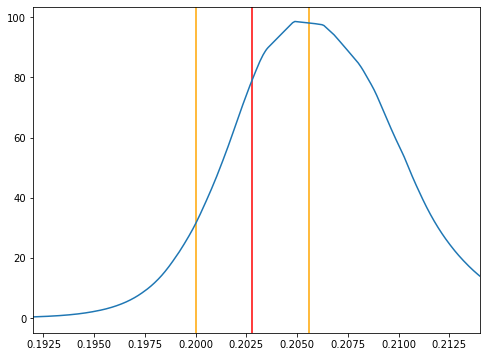

In [87]:
plt.figure(figsize=(8, 6))
for i in [0]:
    z, p = sw.posterior(i, version = -1)
    #plt.axvline(z0[i])
    plt.axvline(.2028,color='red')
    plt.axvline(.2028+.0028,color='orange')
    plt.axvline(.2028-.0028,color='orange')
    #plt.plot(z, stats.norm.pdf(z, z0[i], err[i]), 'k:')
    plt.plot(z, p)
    s = swyft.get_stats(z, p)
    print(s['err68']/.0028)
plt.xlim([0.192, 0.214]);

In [80]:
len(sw.data_store)

80

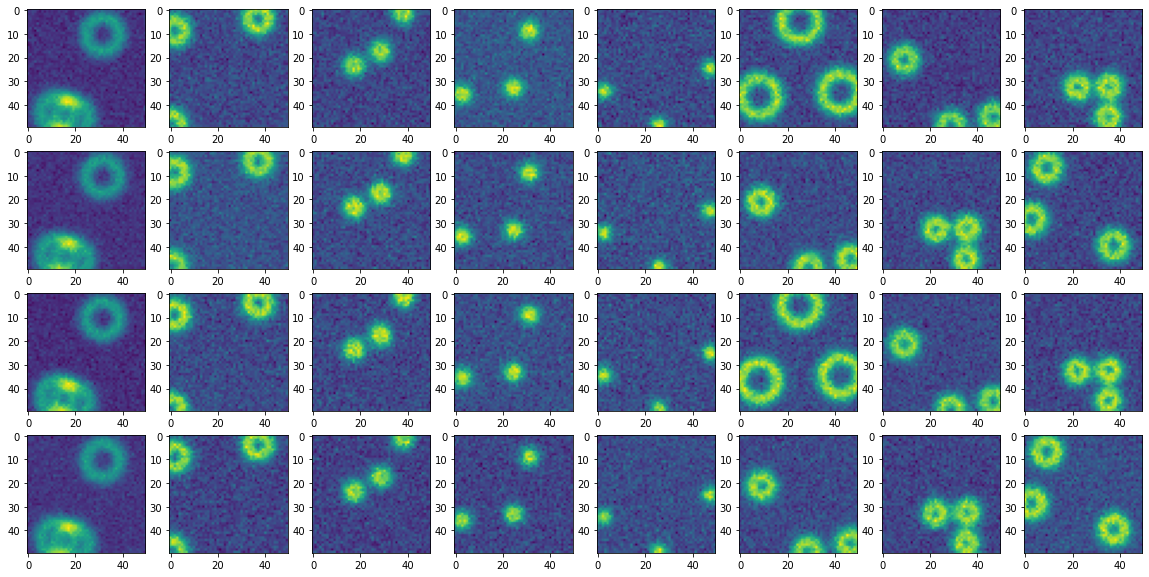

In [18]:
# Training data in different rounds (without noise)

plt.figure(figsize=(20, 10))
counter = 0
for r in range(12,16):
    imgs = swyft.get_x(sw.data_store[r])
    for i in range(8):
        counter += 1
        plt.subplot(4, 8, counter)
        plt.imshow(imgs[i])

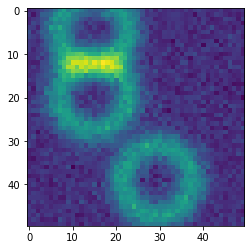

In [88]:
dd=np.array([0.3,0.1,0.3,0.4,0.6,0.8])
z1 = np.array([0.4])
x1 = noisemodel(model(z1,dat=dd))
plt.imshow(x1)

In [97]:
# Instantiate network
sw2 = swyft.SWYFT(x1, model, datastore=sw.ds, zdim = NDIM, device = DEVICE, head = Head, noisemodel = noisemodel)
ch1=time.time()
sw2.run(nworkers=0, nrounds = 8, max_epochs = 50, early_stopping_patience = 2, nsamples = 10000, nbatch = 32, recycle_net = True, threshold = 1e-6)
ch2=time.time()
print(str((ch2-ch1)/60))

Extracting samples.: 100%|██████████| 62338/62338 [00:29<00:00, 2116.35it/s]


Extracted 9907 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 11
Validation losses: [1.897852934896946, 1.8233983144164085, 1.7705186381936073, 1.6024787686765194, 1.5684226304292679, 1.66157865524292, 1.4786162003874779, 1.5251744017004967, 1.4653199389576912, 1.5001781396567822, 1.491365049034357]
LR iteration 1
Total epochs: 5
Validation losses: [1.3314031027257442, 1.340277325361967, 1.3307412303984165, 1.3421966880559921, 1.3961387276649475]
LR iteration 2
Total epochs: 4
Validation losses: [1.351848866790533, 1.3277353942394257, 1.3411274012178183, 1.3464074656367302]


Adding samples.: 100%|██████████| 9974/9974 [00:03<00:00, 2879.59it/s]


Adding 628 new samples.


Extracting samples.: 100%|██████████| 62966/62966 [00:29<00:00, 2130.49it/s]


Extracted 9968 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.784558542072773, 1.6905481070280075, 1.761090226471424, 1.7898556590080261]
LR iteration 1
Total epochs: 5
Validation losses: [1.5761745125055313, 1.6214338466525078, 1.5591114982962608, 1.5685118548572063, 1.5830704122781754]
LR iteration 2
Total epochs: 6
Validation losses: [1.574591413140297, 1.5750514715909958, 1.5400846973061562, 1.5319917127490044, 1.5416892617940903, 1.581084057688713]


Extracting samples.:   0%|          | 292/63295 [00:00<00:21, 2916.64it/s]

Adding 329 new samples.


Extracting samples.: 100%|██████████| 63295/63295 [00:29<00:00, 2130.61it/s]


Extracted 10123 samples
Start training
LR iteration 0
Total epochs: 5
Validation losses: [1.835316188633442, 1.7516107484698296, 1.6564593315124512, 1.7041300907731056, 1.6569465547800064]
LR iteration 1
Total epochs: 4
Validation losses: [1.6120484173297882, 1.559126853942871, 1.5605074614286423, 1.605231486260891]
LR iteration 2
Total epochs: 3
Validation losses: [1.5085310861468315, 1.576876875013113, 1.5829499438405037]


Adding simulations:   0%|          | 0/407 [00:00<?, ?it/s]

Adding 407 new samples.


Extracting samples.: 100%|██████████| 63702/63702 [00:36<00:00, 1734.00it/s]


Extracted 9906 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.739225596189499, 1.6301188096404076, 1.6559445187449455, 1.6672601401805878]
LR iteration 1
Total epochs: 4
Validation losses: [1.4988775923848152, 1.4512705877423286, 1.4905308112502098, 1.4704573079943657]
LR iteration 2
Total epochs: 5
Validation losses: [1.464199610054493, 1.4573794901371002, 1.4195863157510757, 1.4593191370368004, 1.513628751039505]


Adding samples.: 100%|██████████| 10038/10038 [00:04<00:00, 2363.74it/s]


Adding 3090 new samples.


Extracting samples.: 100%|██████████| 66792/66792 [00:38<00:00, 1752.37it/s]


Extracted 9911 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.921483114361763, 1.8713221698999405, 1.906756728887558, 1.8833814710378647]
LR iteration 1
Total epochs: 6
Validation losses: [1.7627108991146088, 1.7187562510371208, 1.7285803109407425, 1.705382764339447, 1.7293007299304008, 1.7719491869211197]
LR iteration 2
Total epochs: 3
Validation losses: [1.6831393390893936, 1.7055933699011803, 1.7144652232527733]


Adding samples.: 100%|██████████| 9805/9805 [00:04<00:00, 2323.09it/s]


Adding 2449 new samples.


Extracting samples.: 100%|██████████| 69241/69241 [00:39<00:00, 1765.91it/s]


Extracted 9912 samples
Start training
LR iteration 0
Total epochs: 6
Validation losses: [1.9492310732603073, 1.923196755349636, 1.9901472181081772, 1.8197263181209564, 1.9349094852805138, 1.9737762063741684]
LR iteration 1
Total epochs: 6
Validation losses: [1.8211943954229355, 1.8021148815751076, 1.8237723857164383, 1.7675454840064049, 1.8293528705835342, 1.9029414504766464]
LR iteration 2
Total epochs: 4
Validation losses: [1.8270788192749023, 1.81234472990036, 1.8124109134078026, 1.8374883979558945]


Adding samples.: 100%|██████████| 9998/9998 [00:03<00:00, 2712.98it/s]


Adding 2358 new samples.


Extracting samples.: 100%|██████████| 71599/71599 [00:33<00:00, 2157.78it/s]


Extracted 9954 samples
Start training
LR iteration 0
Total epochs: 3
Validation losses: [2.0785422176122665, 2.19679993391037, 2.1827429309487343]
LR iteration 1
Total epochs: 5
Validation losses: [2.069481782615185, 2.0393664836883545, 2.0133270546793938, 2.042738914489746, 2.152496039867401]
LR iteration 2
Total epochs: 3
Validation losses: [2.0030520483851433, 2.073407866060734, 2.0322565361857414]


Extracting samples.:   0%|          | 279/71912 [00:00<00:25, 2786.92it/s]

Adding 313 new samples.


Extracting samples.: 100%|██████████| 71912/71912 [00:33<00:00, 2134.23it/s]


Extracted 9885 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.9622758030891418, 1.9532610401511192, 1.9887681975960732, 2.0510708913207054]
LR iteration 1
Total epochs: 7
Validation losses: [1.8540047779679298, 1.8384887129068375, 1.802379123866558, 1.8171379268169403, 1.7973826676607132, 1.8642456382513046, 1.8620220124721527]
LR iteration 2
Total epochs: 4
Validation losses: [1.8358222506940365, 1.8260457888245583, 1.8480452708899975, 1.839941594749689]
14.710487361749014


In [99]:
ch1=time.time()
sw2.run(nworkers=0, nrounds = 4, max_epochs = 50, early_stopping_patience = 2, nsamples = 20000, nbatch = 32, recycle_net = True, threshold = 1e-6)
ch2=time.time()
print(str((ch2-ch1)/60))

Adding samples.: 100%|██████████| 19723/19723 [00:07<00:00, 2605.39it/s]


Adding 10901 new samples.


Extracting samples.: 100%|██████████| 82813/82813 [00:37<00:00, 2181.61it/s]


Extracted 19756 samples
Start training
LR iteration 0
Total epochs: 5
Validation losses: [2.2630492076277733, 2.2408048436045647, 2.2132450118660927, 2.30062148720026, 2.2173988297581673]
LR iteration 1
Total epochs: 4
Validation losses: [2.233532063663006, 2.1784655898809433, 2.2154745534062386, 2.2789712622761726]
LR iteration 2
Total epochs: 5
Validation losses: [2.18783663213253, 2.2444136142730713, 2.151248000562191, 2.2139684930443764, 2.238884299993515]


Adding samples.: 100%|██████████| 20050/20050 [00:07<00:00, 2546.99it/s]


Adding 3018 new samples.


Extracting samples.: 100%|██████████| 85831/85831 [00:39<00:00, 2159.89it/s]


Extracted 19845 samples
Start training
LR iteration 0
Total epochs: 6
Validation losses: [2.135060615837574, 2.134679950773716, 2.1759975776076317, 2.1172521114349365, 2.2113254442811012, 2.200585648417473]
LR iteration 1
Total epochs: 6
Validation losses: [2.080378755927086, 2.055011324584484, 2.0456146001815796, 2.018121160566807, 2.043883390724659, 2.048001654446125]
LR iteration 2
Total epochs: 3
Validation losses: [2.0097582563757896, 2.129994086921215, 2.08229847997427]


Adding samples.: 100%|██████████| 20069/20069 [00:08<00:00, 2504.32it/s]


Adding 3177 new samples.


Extracting samples.: 100%|██████████| 89008/89008 [00:40<00:00, 2191.70it/s]


Extracted 19863 samples
Start training
LR iteration 0
Total epochs: 3
Validation losses: [2.157475031912327, 2.1719141602516174, 2.2695192247629166]
LR iteration 1
Total epochs: 3
Validation losses: [1.9950809106230736, 2.0458462312817574, 2.0184915363788605]
LR iteration 2
Total epochs: 8
Validation losses: [1.9959780350327492, 1.9683989882469177, 1.9943287894129753, 1.9468265175819397, 1.9711612910032272, 1.897701807320118, 2.032843217253685, 1.9546615108847618]


Extracting samples.:   1%|          | 541/89151 [00:00<00:32, 2710.99it/s]

Adding 143 new samples.


Extracting samples.: 100%|██████████| 89151/89151 [00:41<00:00, 2133.04it/s]


Extracted 19844 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.9264198243618011, 1.8600627854466438, 1.9219733700156212, 1.8896250128746033]
LR iteration 1
Total epochs: 5
Validation losses: [1.7146558612585068, 1.6975297406315804, 1.6532051116228104, 1.6815201044082642, 1.7255512923002243]
LR iteration 2
Total epochs: 4
Validation losses: [1.698582723736763, 1.6838432475924492, 1.7417078912258148, 1.7106897607445717]
12.57495733499527


In [101]:
ch1=time.time()
sw2.run(nworkers=0, nrounds = 2, max_epochs = 50, early_stopping_patience = 1, nsamples = 20000, nbatch = 512, recycle_net = True, threshold = 1e-6)
ch2=time.time()
print(str((ch2-ch1)/60))

Extracting samples.:   0%|          | 229/89328 [00:00<00:38, 2285.51it/s]

Adding 177 new samples.


Extracting samples.: 100%|██████████| 89328/89328 [00:50<00:00, 1762.98it/s]


Extracted 19866 samples
Start training
LR iteration 0
Total epochs: 2
Validation losses: [1.7673637866973877, 1.7699532508850098]
LR iteration 1
Total epochs: 2
Validation losses: [1.7430462837219238, 1.757728099822998]
LR iteration 2
Total epochs: 2
Validation losses: [1.7427589893341064, 1.750009298324585]


Extracting samples.:   1%|          | 452/89342 [00:00<00:39, 2261.07it/s]

Adding 14 new samples.


Extracting samples.: 100%|██████████| 89342/89342 [00:51<00:00, 1750.81it/s]


Extracted 19770 samples
Start training
LR iteration 0
Total epochs: 2
Validation losses: [1.7183926105499268, 1.7346159219741821]
LR iteration 1
Total epochs: 3
Validation losses: [1.680598497390747, 1.6700350046157837, 1.6853379011154175]
LR iteration 2
Total epochs: 2
Validation losses: [1.678686261177063, 1.7043037414550781]
3.8636760393778484


In [103]:
ch1=time.time()
sw2.run(nworkers=0, nrounds = 2, max_epochs = 50, early_stopping_patience = 1, nsamples = 20000, nbatch = 512, recycle_net = False, threshold = 1e-6)
ch2=time.time()
print(str((ch2-ch1)/60))

Extracting samples.:   0%|          | 222/89533 [00:00<00:40, 2217.61it/s]

Adding 191 new samples.


Extracting samples.: 100%|██████████| 89533/89533 [00:51<00:00, 1735.27it/s]


Extracted 19877 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 9
Validation losses: [2.7720532417297363, 2.771899461746216, 2.7613000869750977, 2.708829641342163, 2.6622281074523926, 2.6349756717681885, 2.5879368782043457, 2.5537335872650146, 2.560269832611084]
LR iteration 1
Total epochs: 3
Validation losses: [2.5237014293670654, 2.5094220638275146, 2.5248513221740723]
LR iteration 2
Total epochs: 3
Validation losses: [2.491117000579834, 2.4605917930603027, 2.5158073902130127]


Adding samples.: 100%|██████████| 19994/19994 [00:09<00:00, 2029.63it/s]


Adding 4299 new samples.


Extracting samples.: 100%|██████████| 93832/93832 [00:53<00:00, 1743.51it/s]


Extracted 19632 samples
Number of output features: 160
Start training
LR iteration 0
Total epochs: 6
Validation losses: [2.6603033542633057, 2.1878108978271484, 1.9709055423736572, 1.862876296043396, 1.8228685855865479, 1.875065803527832]
LR iteration 1
Total epochs: 4
Validation losses: [1.7562849521636963, 1.730591893196106, 1.7196669578552246, 1.74135422706604]
LR iteration 2
Total epochs: 2
Validation losses: [1.7308330535888672, 1.7480390071868896]
5.389381790161133


In [105]:
ch1=time.time()
sw2.run(nworkers=0, nrounds = 8, max_epochs = 50, early_stopping_patience = 1, nsamples = 20000, nbatch = 512, recycle_net = True, threshold = 1e-6)
ch2=time.time()
print(str((ch2-ch1)/60))

Adding samples.: 100%|██████████| 20304/20304 [00:07<00:00, 2668.70it/s]


Adding 5490 new samples.


Extracting samples.: 100%|██████████| 99322/99322 [00:46<00:00, 2137.44it/s]


Extracted 20070 samples
Start training
LR iteration 0
Total epochs: 7
Validation losses: [2.1709001064300537, 1.9568283557891846, 1.8301396369934082, 1.716829538345337, 1.6960346698760986, 1.5829311609268188, 1.6583752632141113]
LR iteration 1
Total epochs: 4
Validation losses: [1.5248292684555054, 1.5047070980072021, 1.4775128364562988, 1.5043458938598633]
LR iteration 2
Total epochs: 4
Validation losses: [1.4807205200195312, 1.473678469657898, 1.4460930824279785, 1.4767823219299316]


Extracting samples.:   0%|          | 263/99704 [00:00<00:37, 2624.71it/s]

Adding 382 new samples.


Extracting samples.: 100%|██████████| 99704/99704 [00:47<00:00, 2107.25it/s]


Extracted 19992 samples
Start training
LR iteration 0
Total epochs: 6
Validation losses: [1.8040263652801514, 1.4910273551940918, 1.3409748077392578, 1.307276964187622, 1.285715103149414, 1.299160122871399]
LR iteration 1
Total epochs: 4
Validation losses: [1.243933916091919, 1.2412570714950562, 1.224733591079712, 1.2494254112243652]
LR iteration 2
Total epochs: 2
Validation losses: [1.190671682357788, 1.2050268650054932]


Adding samples.: 100%|██████████| 19933/19933 [00:08<00:00, 2472.94it/s]


Adding 2350 new samples.


Extracting samples.: 100%|██████████| 102054/102054 [00:48<00:00, 2083.94it/s]


Extracted 19911 samples
Start training
LR iteration 0
Total epochs: 7
Validation losses: [2.1198720932006836, 1.6801934242248535, 1.6352972984313965, 1.572253942489624, 1.5477700233459473, 1.4941110610961914, 1.5408140420913696]
LR iteration 1
Total epochs: 2
Validation losses: [1.496848225593567, 1.5084282159805298]
LR iteration 2
Total epochs: 2
Validation losses: [1.4811201095581055, 1.5030014514923096]


Adding samples.: 100%|██████████| 20120/20120 [00:08<00:00, 2350.54it/s]


Adding 1540 new samples.


Extracting samples.: 100%|██████████| 103594/103594 [00:58<00:00, 1783.83it/s]


Extracted 19761 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.8715269565582275, 1.7007665634155273, 1.6724143028259277, 1.7183421850204468]
LR iteration 1
Total epochs: 3
Validation losses: [1.6747734546661377, 1.6292035579681396, 1.6397655010223389]
LR iteration 2
Total epochs: 2
Validation losses: [1.6533252000808716, 1.65690016746521]


Adding samples.: 100%|██████████| 20103/20103 [00:10<00:00, 1935.35it/s]


Adding 1097 new samples.


Extracting samples.: 100%|██████████| 104691/104691 [00:58<00:00, 1776.54it/s]


Extracted 19745 samples
Start training
LR iteration 0
Total epochs: 3
Validation losses: [1.9042600393295288, 1.78263258934021, 1.823574185371399]
LR iteration 1
Total epochs: 6
Validation losses: [1.6704418659210205, 1.6543331146240234, 1.6477547883987427, 1.6463680267333984, 1.6163157224655151, 1.633453130722046]
LR iteration 2
Total epochs: 4
Validation losses: [1.6591730117797852, 1.6473853588104248, 1.6268796920776367, 1.6320171356201172]


Adding samples.: 100%|██████████| 20191/20191 [00:08<00:00, 2260.55it/s]


Adding 671 new samples.


Extracting samples.: 100%|██████████| 105362/105362 [00:51<00:00, 2055.77it/s]


Extracted 19603 samples
Start training
LR iteration 0
Total epochs: 5
Validation losses: [1.9062610864639282, 1.8920738697052002, 1.8739041090011597, 1.8347110748291016, 1.91813325881958]
LR iteration 1
Total epochs: 4
Validation losses: [1.7946324348449707, 1.7697763442993164, 1.7356081008911133, 1.7741374969482422]
LR iteration 2
Total epochs: 2
Validation losses: [1.7559045553207397, 1.7786026000976562]


Adding samples.: 100%|██████████| 20217/20217 [00:09<00:00, 2157.43it/s]


Adding 1844 new samples.


Extracting samples.: 100%|██████████| 107206/107206 [00:52<00:00, 2037.31it/s]


Extracted 19760 samples
Start training
LR iteration 0
Total epochs: 6
Validation losses: [2.0842418670654297, 1.9694085121154785, 1.9027103185653687, 1.8355796337127686, 1.832136869430542, 1.8615630865097046]
LR iteration 1
Total epochs: 4
Validation losses: [1.8122265338897705, 1.8014678955078125, 1.7630279064178467, 1.7818241119384766]
LR iteration 2
Total epochs: 2
Validation losses: [1.7415602207183838, 1.8067066669464111]


Adding samples.: 100%|██████████| 19968/19968 [00:09<00:00, 2122.52it/s]


Adding 428 new samples.


Extracting samples.: 100%|██████████| 107634/107634 [00:54<00:00, 1990.81it/s]


Extracted 19828 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.689276099205017, 1.5489392280578613, 1.5388274192810059, 1.581376552581787]
LR iteration 1
Total epochs: 2
Validation losses: [1.481109857559204, 1.5041334629058838]
LR iteration 2
Total epochs: 2
Validation losses: [1.4716233015060425, 1.5129362344741821]
18.79247526327769


In [107]:
ch1=time.time()
sw2.run(nworkers=0, nrounds = 2, max_epochs = 50, early_stopping_patience = 1, nsamples = 20000, nbatch = 512, recycle_net = True, threshold = 1e-6)
ch2=time.time()
print(str((ch2-ch1)/60))

Adding samples.: 100%|██████████| 20249/20249 [00:09<00:00, 2072.45it/s]


Adding 903 new samples.


Extracting samples.: 100%|██████████| 108537/108537 [00:59<00:00, 1818.34it/s]


Extracted 19692 samples
Start training
LR iteration 0
Total epochs: 6
Validation losses: [1.8630759716033936, 1.783576488494873, 1.7387728691101074, 1.7105045318603516, 1.6971027851104736, 1.7439566850662231]
LR iteration 1
Total epochs: 2
Validation losses: [1.637954831123352, 1.6722114086151123]
LR iteration 2
Total epochs: 2
Validation losses: [1.625216007232666, 1.6590654850006104]


Extracting samples.:   0%|          | 251/108859 [00:00<00:43, 2507.60it/s]

Adding 322 new samples.


Extracting samples.: 100%|██████████| 108859/108859 [00:53<00:00, 2017.05it/s]


Extracted 19645 samples
Start training
LR iteration 0
Total epochs: 3
Validation losses: [1.9445505142211914, 1.8059660196304321, 1.821009874343872]
LR iteration 1
Total epochs: 4
Validation losses: [1.7890126705169678, 1.7790154218673706, 1.74567711353302, 1.7579166889190674]
LR iteration 2
Total epochs: 2
Validation losses: [1.7642252445220947, 1.7835783958435059]
4.51459817091624


In [ ]:
ch1=time.time()
sw2.run(nworkers=0, nrounds = 8, max_epochs = 50, early_stopping_patience = 1, nsamples = 20000, nbatch = 512, recycle_net = True, threshold = 1e-6)
ch2=time.time()
print(str((ch2-ch1)/60))

Extracting samples.:   0%|          | 487/108976 [00:00<00:44, 2446.34it/s]

Adding 117 new samples.


Extracting samples.: 100%|██████████| 108976/108976 [00:54<00:00, 2004.99it/s]


Extracted 19643 samples
Start training
LR iteration 0
Total epochs: 5
Validation losses: [1.6919138431549072, 1.6396781206130981, 1.63730788230896, 1.6212217807769775, 1.65944504737854]
LR iteration 1
Total epochs: 2
Validation losses: [1.5894298553466797, 1.5949780941009521]
LR iteration 2
Total epochs: 2
Validation losses: [1.5324996709823608, 1.5588014125823975]


Extracting samples.:   0%|          | 246/109285 [00:00<00:44, 2454.78it/s]

Adding 309 new samples.


Extracting samples.: 100%|██████████| 109285/109285 [00:59<00:00, 1822.95it/s]


Extracted 19771 samples
Start training
LR iteration 0
Total epochs: 3
Validation losses: [1.8376840353012085, 1.6827874183654785, 1.7506550550460815]
LR iteration 1
Total epochs: 3
Validation losses: [1.70485520362854, 1.6640268564224243, 1.694329857826233]
LR iteration 2
Total epochs: 2
Validation losses: [1.677625298500061, 1.705739974975586]


Extracting samples.:   0%|          | 206/109448 [00:00<00:53, 2055.45it/s]

Adding 163 new samples.


Extracting samples.: 100%|██████████| 109448/109448 [01:07<00:00, 1626.16it/s]


Extracted 19808 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.7902549505233765, 1.7106825113296509, 1.707726240158081, 1.7714474201202393]
LR iteration 1
Total epochs: 2
Validation losses: [1.6815924644470215, 1.6997935771942139]
LR iteration 2
Total epochs: 2
Validation losses: [1.6588054895401, 1.694190502166748]


Extracting samples.:   0%|          | 483/109476 [00:00<00:44, 2423.15it/s]

Adding 28 new samples.


Extracting samples.: 100%|██████████| 109476/109476 [00:55<00:00, 1961.96it/s]


Extracted 19691 samples
Start training
LR iteration 0
Total epochs: 2
Validation losses: [1.7093499898910522, 1.7179834842681885]
LR iteration 1
Total epochs: 2
Validation losses: [1.6255009174346924, 1.6340423822402954]
LR iteration 2
Total epochs: 3
Validation losses: [1.6346163749694824, 1.6263272762298584, 1.640716552734375]


Extracting samples.:   0%|          | 474/109506 [00:00<00:45, 2382.13it/s]

Adding 30 new samples.


Extracting samples.: 100%|██████████| 109506/109506 [00:56<00:00, 1949.42it/s]


Extracted 19621 samples
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.6779978275299072, 1.6195402145385742, 1.6127827167510986, 1.7270621061325073]
LR iteration 1
Total epochs: 3
Validation losses: [1.5548678636550903, 1.5486115217208862, 1.6104955673217773]
LR iteration 2
Total epochs: 2
Validation losses: [1.5637532472610474, 1.568118929862976]


Adding samples.:  97%|█████████▋| 19155/19762 [00:10<00:00, 1873.82it/s]

2.276676582677076


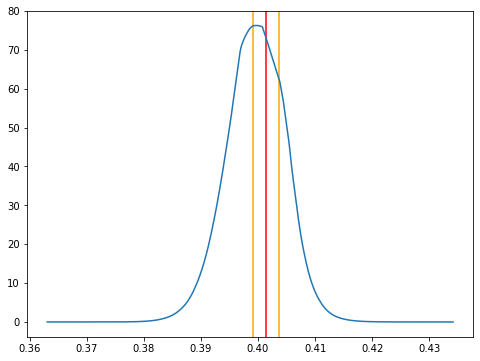

In [108]:
plt.figure(figsize=(8, 6))
for i in [0]:
    z, p = sw2.posterior(i, version = -1)
    #plt.axvline(z0[i])
    plt.axvline(.4014,color='red')
    plt.axvline(.4014+.0022,color='orange')
    plt.axvline(.4014-.0022,color='orange')
    #plt.plot(z, stats.norm.pdf(z, z0[i], err[i]), 'k:')
    plt.plot(z, p)
    s = swyft.get_stats(z, p)
    print(s['err68']/.0022)
#plt.xlim([0.192, 0.214]);

# 2-dim plots

In [ ]:
ch1=time.time()
sw.comb([[0, 1]],nworkers=0)
ch2=time.time()
print(str((ch2-ch1)/60))

In [ ]:
zgrid, lnLgrid = sw.posterior([0, 1])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], -lnLgrid+max_lnL, levels = [1, 4, 9, 16, 50])
#plt.xlim([0, 1])
#plt.ylim([0, 1])

In [ ]:
ch1=time.time()
sw.comb([[0, 2]],nworkers=0)
ch2=time.time()
print(str((ch2-ch1)/60))

In [ ]:
zgrid, lnLgrid = sw.posterior([0, 2])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], -lnLgrid+max_lnL, levels = [1, 4, 9, 16, 50])
#plt.xlim([0, 1])
#plt.ylim([0, 1])

In [ ]:
ch1=time.time()
sw.comb([[0, 3]],nworkers=0)
ch2=time.time()
print(str((ch2-ch1)/60))

In [ ]:
zgrid, lnLgrid = sw.posterior([0, 3])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], -lnLgrid+max_lnL, levels = [1, 4, 9, 16, 50])
#plt.xlim([0, 1])
#plt.ylim([0, 1])

In [ ]:
ch1=time.time()
sw.comb([[1,2]],nworkers=0)
ch2=time.time()
print(str((ch2-ch1)/60))

In [ ]:
zgrid, lnLgrid = sw.posterior([1,2])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], -lnLgrid+max_lnL, levels = [1, 4, 9, 16, 50])
#plt.xlim([0, 1])
#plt.ylim([0, 1])

In [ ]:
ch1=time.time()
sw.comb([[1,3]],nworkers=0)
ch2=time.time()
print(str((ch2-ch1)/60))

In [ ]:
zgrid, lnLgrid = sw.posterior([1,3])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], -lnLgrid+max_lnL, levels = [1, 4, 9, 16, 50])
#plt.xlim([0, 1])
#plt.ylim([0, 1])

In [ ]:
ch1=time.time()
sw.comb([[2,3]],nworkers=0)
ch2=time.time()
print(str((ch2-ch1)/60))

In [ ]:
zgrid, lnLgrid = sw.posterior([2,3])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], -lnLgrid+max_lnL, levels = [1, 4, 9, 16, 50])
#plt.xlim([0, 1])
#plt.ylim([0, 1])